# Tutorial: Su-Schrieffer-Heeger (SSH) Model

This notebook provides a comprehensive guide to simulating High Harmonic Generation (HHG) in the SSH model. It covers:
1.  **Standard HHG**: Basic spectrum calculation.
2.  **Current Decomposition (CD)**: Analyzing contributions from Bulk vs. Edge states.

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

if os.getcwd() not in sys.path:
    sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from hhg.models import SSHModel
from hhg.fields import SinSquaredPulse
from hhg.solvers import TimeEvolver
from hhg.analysis import compute_dipole_acceleration, compute_hhg_spectrum
from hhg.analysis.decomposition import run_current_decomposition

## 1. Model Initialization

We initialize the SSH model in its **Topological Phase** (`delta < 0`).


In [2]:
# Define Parameters
N = 100
a = 2.0
dt = 0.1
omega = 0.0075
ncyc = 5
A0 = 0.2

# SSH Topological
model = SSHModel(N=N, delta=-0.15, V_A=0.0)

# Define Pulse
pulse = SinSquaredPulse(A0=A0, omega=omega, ncyc=ncyc)

## 2. Standard HHG Spectrum

We calculate the dipole acceleration and the resulting harmonic spectrum for the whole system.


Running Standard HHG...


Evolution: 100%|██████████| 41888/41888 [00:28<00:00, 1487.92it/s]


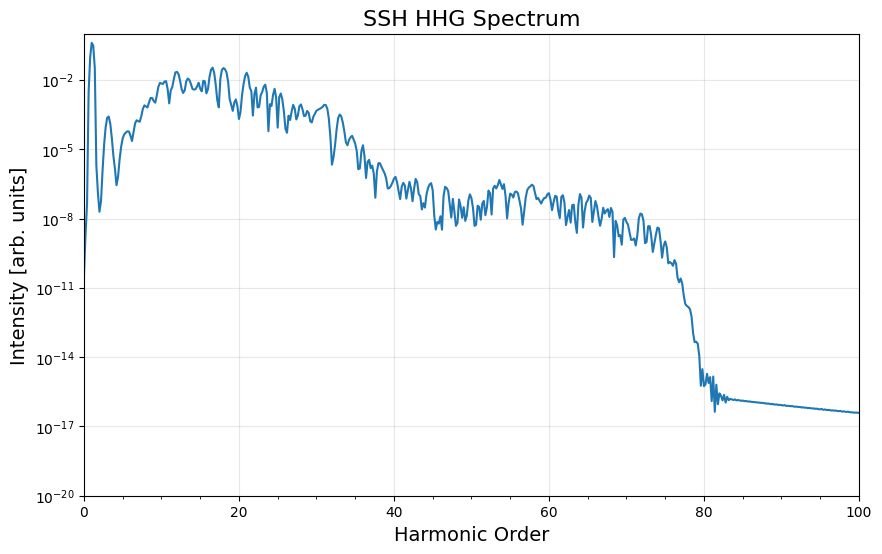

In [ ]:
print("Running Standard HHG...")
evolver = TimeEvolver(model)
t_max = 2 * np.pi * ncyc / omega

# Get initial State
psi0 = model.get_ground_state()

# Time Evolution
iterator = evolver.evolve(pulse, t_max, dt, initial_state=psi0)

X_t = []
for step, t, psi in iterator:
    x_val = np.einsum('ij,i,ij->', np.conj(psi), model.positions, psi).real
    X_t.append(x_val)

acc = compute_dipole_acceleration(np.array(X_t), dt)
harm, spec = compute_hhg_spectrum(acc, dt, omega)

plt.figure(figsize=(10, 6), dpi=100)
plt.semilogy(harm, spec)
plt.title('SSH HHG Spectrum', fontsize=16)
plt.xlabel('Harmonic Order', fontsize=14)
plt.ylabel('Intensity [arb. units]', fontsize=14)
plt.xlim(0, 100)
plt.ylim(1e-20, 1e0)
plt.grid(True, alpha=0.3)
plt.minorticks_on()
plt.show()

## 3. Current Decomposition (CD)

We decompose the current into contributions from the **Bulk (Valence Band)** and the **Topological Edge States**.


Running Current Decomposition...


Evolution:   0%|          | 0/41888 [00:00<?, ?it/s]

Evolution: 100%|██████████| 41888/41888 [00:27<00:00, 1535.32it/s]


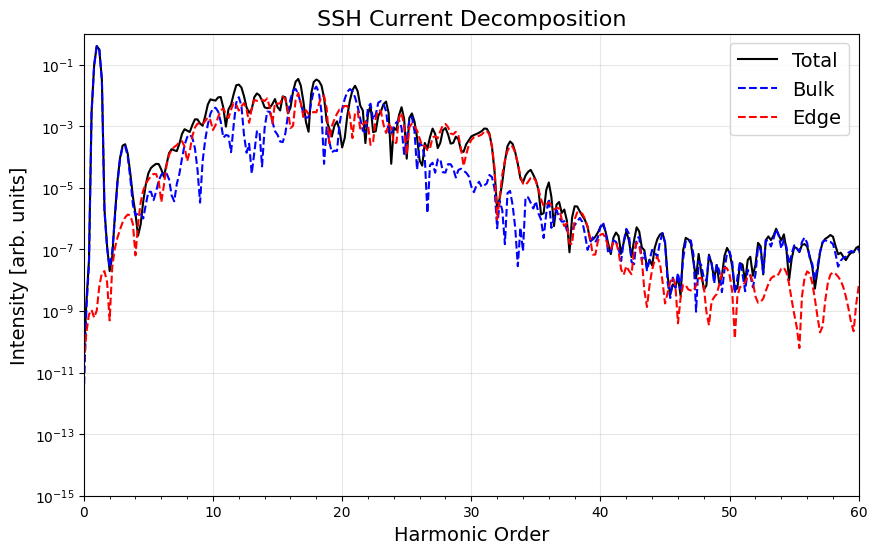

In [ ]:
print("Running Current Decomposition...")
times, dipoles = run_current_decomposition(model, pulse, dt=dt, ncyc=ncyc, omega=omega)

# SSH separation keys: 'occ', 'VB', 'ES'
w, I_total = compute_hhg_spectrum(dipoles['occ'], dt, omega)
w, I_bulk  = compute_hhg_spectrum(dipoles['VB'], dt, omega)
w, I_edge  = compute_hhg_spectrum(dipoles['ES'], dt, omega)

plt.figure(figsize=(10, 6), dpi=100)
plt.semilogy(w, I_total, 'k-', label='Total')
plt.semilogy(w, I_bulk, 'b--', label='Bulk')
plt.semilogy(w, I_edge, 'r--', label='Edge')
plt.title('SSH Current Decomposition', fontsize=16)
plt.xlabel('Harmonic Order', fontsize=14)
plt.ylabel('Intensity [arb. units]', fontsize=14)
plt.legend(fontsize=14)
plt.grid(True, alpha=0.3)
plt.minorticks_on()
plt.xlim(0, 60)
plt.ylim(1e-15, 1e0)
plt.show()
